# Waves, Cycles and the Shape of COVID Outbreaks
In research you often start out with the kernel of an idea only to take a detour from your original exploration that leads you to a more interesting destination. That is what happened in this work, which began with me looking at COVID prevalence and transmission rates and ended up with an interesting way to visualise how different countries have responded to the pandemic and what this tells us about their responses.

In [42]:
from datetime import date, datetime, timedelta


import pandas as pd
import numpy as np

from loguru import logger
import pycountry

from matplotlib.pylab import plt
import matplotlib


import seaborn as sns

import plotly.io as pio
import plotly_express as px

import chart_studio.plotly as py
import chart_studio

from IPython.display import clear_output


import sys
import os
sys.path.insert(0, os.path.abspath('../src/'))
import pipeline


%matplotlib inline

!pwd

/home/barry/projects/covid_projects/metrics


# Load OWID Base Dataset 

In [43]:
df = pd.read_pickle('../generating_covid_datasets/data/base_owid.pkl')
df.shape, df['country'].nunique(), df.date.max()

((40351, 10), 208, Timestamp('2020-09-02 00:00:00'))

# Main Data Pipeline

In [44]:
recency_period = '14d'
def compute_recent_deaths(df, deaths_col='new_deaths_per_100k_rolling', recency_period=recency_period):
    
    recent_deaths_col = 'recent_deaths_{}'.format(recency_period)
    
    # The sum of the new deaths during the infectous period.
    recent_deaths = df.groupby('country')\
        .apply(lambda g: g.set_index('date')[[deaths_col]].rolling(recency_period).sum().clip(lower=.01))\
        .rename(columns={deaths_col: recent_deaths_col})
    
    return df.set_index(['country', 'date']).join(recent_deaths).reset_index()


# fatality_prevalence_lag = 21

# def compute_fatality_ratio(df, deaths_col='new_deaths_per_100k_rolling', prevalence_col='prevalence_14d', prevalence_lag=fatality_prevalence_lag):
    
#     use_col = 'fatality_ratio_{}d'.format(prevalence_lag)
    
#     new_deaths_per_lagged_prevalence = pd.DataFrame(
#         df.groupby('country').apply(lambda g: g.set_index('date')[deaths_col]/g.set_index('date')[prevalence_col].shift(prevalence_lag)),
#         columns=[use_col])
        
#     return df.set_index(['country', 'date']).join(new_deaths_per_lagged_prevalence).reset_index()
    


df = df.pipe(pipeline.compute_per_100k)\
    .pipe(pipeline.compute_totals_per_100k)\
    .pipe(pipeline.compute_rolling)\
    .pipe(pipeline.compute_prevalence)\
    .pipe(compute_recent_deaths)\
    .pipe(pipeline.compute_transmission_ratio)\
#     .pipe(compute_fatality_ratio)

df.tail()

,country,date,country_code,country_id,continent,region,new_cases,new_deaths,new_tests_smoothed,population,...,total_tests_smoothed_per_100k,new_cases_per_100k_rolling,new_deaths_per_100k_rolling,new_tests_smoothed_per_100k_rolling,total_cases_per_100k_rolling,total_deaths_per_100k_rolling,total_tests_smoothed_per_100k_rolling,new_cases_per_100k_rolling_prevalence_14d,recent_deaths_14d,new_cases_per_100k_rolling_transmission_ratio_7d
40346,Zimbabwe,2020-08-29,ZWE,ZW,Africa,east_africa,96.0,6.0,NaN,14862927.0,...,NaN,0.550747,0.041330,7.950430,41.349287,1.145708,548.267960,8.914799,0.384466,0.061846
40347,Zimbabwe,2020-08-30,ZWE,ZW,Africa,east_africa,18.0,1.0,NaN,14862927.0,...,NaN,0.493077,0.041330,7.874627,41.842364,1.187038,552.300365,8.830216,0.398883,0.056585
40348,Zimbabwe,2020-08-31,ZWE,ZW,Africa,east_africa,6.0,0.0,NaN,14862927.0,...,NaN,0.463281,0.039408,7.792880,42.305645,1.226446,556.298568,8.705265,0.411378,0.053514
40349,Zimbabwe,2020-09-01,ZWE,ZW,Africa,east_africa,85.0,6.0,NaN,14862927.0,...,NaN,0.410417,0.045175,7.544499,42.716062,1.271620,560.116232,8.577430,0.426757,0.046944
40350,Zimbabwe,2020-09-02,ZWE,ZW,Africa,east_africa,62.0,1.0,NaN,14862927.0,...,NaN,0.348903,0.035563,7.404329,43.064965,1.307183,563.839142,8.388081,0.426757,0.038961


# Prevalence & Transmission Ratio
One way to think about *prevalence (P)* is that it is the number of active cases -- strictly speaking it's the number of active infections but we are working with data about confirmed cases rather than true infections -- which in the case of COVID-19 is roughly the sum of the new case over the previous 14 days; its a metric that is often used in the reporting about COVID numbers, especially in areas where new daily cases are much lower than their previous highs.

As I was thinking about the relationship between new cases and prevalence it occured to be that the ratio between today's new cases and prevalence, from a few days ago, was an interesting and meaningful measure. Today's new cases are presumably the result of an infection event a few days ago (let's assume an average of 7 days ago) when there was a particular prevalence of cases/infections. Therefore, the number of new cases today as a fraction of prevalence 7 days ago is an rough approximation of the average number of transmissions per casde from 7 days ago. For example, if there were 1,000 cases 7 days ago and 100 new cases today then 1 in 10 of these 1,000 cases led to a new infection 7 days ago. We call this metric the *transmission ratio (TR)*.

If that sounds familiar it is because it is related to the now famous r-number, the average number of new people that an infected person goes on to infect. So why do we need a new measure? Why not just use *r*? One of the problems with *r* is that it is difficult and complicated to compute whereas the measure above, which is moderately well correlated with *r*, is very straightforward to calculate from case numbers alone, which can be useful as a more agile metric for gaining early insights into transmission.

In [45]:
# sns.set_context('talk')

# fig, ax = plt.subplots(figsize=(12, 8))

# country = 'Ireland'

# data = df[df['country']==country].set_index('date').loc[datetime(2020, 4, 1):]

# def plot_new_cases_and_transmission_rate(data, ax):

#     c = data['new_cases_per_100k_rolling']
#     c.plot(ax=ax, lw=3)
#     ax.fill_between(c.index, 0, c, color='cornflowerblue', alpha=.1)

#     bx = ax.twinx()
#     tr = data['new_cases_per_100k_rolling_transmission_ratio_7d']
#     tr.plot(ax=bx, color='firebrick', lw=3)
#     bx.fill_between(tr.index, 0, tr, color='firebrick', alpha=.1)

#     ax.set_title(country)
    
#     ax.set_ylim(0)
#     bx.set_ylim(0)
    
#     bx.set_yticks([])
    
#     return ax, bx

# ax, bx = plot_new_cases_and_transmission_rate(data, ax)



# ax.set_xlabel('Date')
# ax.set_ylabel('New Daily Cases (per 100k)')
# bx.set_ylabel('Transmission Rate (7d)')

# ax.legend(['New Cases'], frameon=False, loc=2)
# bx.legend(['Transmission Rate'], frameon=False, loc=1)

# ax.set_ylim(0, 25)
# bx.set_ylim(0, 0.49)

# bx.set_yticks(np.arange(0, .81, .2))
# bx.set_ylabel('Transmission Ratio (7d)')




# c = data['new_cases_per_100k_rolling']
# tr = data['new_cases_per_100k_rolling_transmission_ratio_7d']

# tr_rise_start = datetime(2020, 6, 25)
# tr_drop_start = datetime(2020, 8, 9)


# ax.annotate(
#     'New Cases Peak ({})\n{} cases/100k'.format(c.idxmax().strftime('%d %b'), round(c.max(), 2)), 
#     xy=(c.idxmax(), c.max()), xytext=(c.idxmax()+timedelta(days=35), c.max()+2),
#     arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=2),
#     bbox=dict(facecolor='ghostwhite', edgecolor='black', boxstyle='round,pad=.4', lw=2), 
#     style='oblique', ha='center'
# )

# bx.annotate(
#     'TR rising ahead of\nprevalence from late June'.format(round(p.max(), 2)), 
#     xy=(tr_rise_start, tr.loc[tr_rise_start]), xytext=(tr_rise_start-timedelta(days=5), tr.loc[tr_rise_start]+.2),
#     arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=2),
#     bbox=dict(facecolor='seashell', edgecolor='black', boxstyle='round,pad=.4', lw=2), 
#     style='oblique', ha='center'
# )

# bx.annotate(
#     'TR begins steady decline\nindicating slowing\nnew case growth to come'.format(round(p.max(), 2)), 
#     xy=(tr_drop_start, tr.loc[tr_drop_start]), xytext=(tr_drop_start-timedelta(days=20), tr.loc[tr_drop_start]+.2),
#     arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=2),
#     bbox=dict(facecolor='seashell', edgecolor='black', boxstyle='round,pad=.4', lw=2), 
#     style='oblique', ha='center'
# )



# fig.tight_layout()

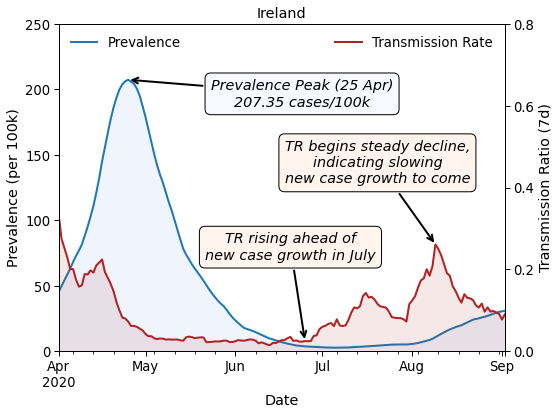

In [76]:
sns.set_context('paper', font_scale=1.5)

fig, ax = plt.subplots(figsize=(8, 6))

country = 'Ireland'

data = df[df['country']==country].set_index('date').loc[datetime(2020, 4, 1):]

def plot_prevalence_and_transmission_rate(data, ax):

    p = data['new_cases_per_100k_rolling_prevalence_14d']
    p.plot(ax=ax, lw=2)
    ax.fill_between(p.index, 0, p, color='cornflowerblue', alpha=.1)

    bx = ax.twinx()
    tr = data['new_cases_per_100k_rolling_transmission_ratio_7d']
    tr.plot(ax=bx, color='firebrick', lw=2)
    bx.fill_between(tr.index, 0, tr, color='firebrick', alpha=.1)

    ax.set_title(country)
    
    return ax, bx

ax, bx = plot_prevalence_and_transmission_rate(data, ax)



ax.set_xlabel('Date')
ax.set_ylabel('Prevalence (per 100k)')
bx.set_ylabel('Transmission Rate (7d)')

ax.legend(['Prevalence'], frameon=False, loc=2)
bx.legend(['Transmission Rate'], frameon=False, loc=1)

ax.set_ylim(0, 250)
bx.set_ylim(0, 0.49)

bx.set_yticks(np.arange(0, .81, .2))
bx.set_ylabel('Transmission Ratio (7d)')


p = data['new_cases_per_100k_rolling_prevalence_14d']
tr = data['new_cases_per_100k_rolling_transmission_ratio_7d']



ax.annotate(
    'Prevalence Peak ({})\n{} cases/100k'.format(p.idxmax().strftime('%d %b'), round(p.max(), 2)), 
    xy=(p.idxmax(), p.max()), xytext=(p.idxmax()+timedelta(days=60), p.max()-20),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=2),
    bbox=dict(facecolor='ghostwhite', edgecolor='black', boxstyle='round,pad=.4', lw=1), 
    style='oblique', ha='center'
)


tr_rise_start = datetime(2020, 6, 25)
tr_drop_start = datetime(2020, 8, 9)

bx.annotate(
    'TR rising ahead of\nnew case growth in July'.format(round(p.max(), 2)), 
    xy=(tr_rise_start, tr.loc[tr_rise_start]), xytext=(tr_rise_start-timedelta(days=5), tr.loc[tr_rise_start]+.2),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=2),
    bbox=dict(facecolor='seashell', edgecolor='black', boxstyle='round,pad=.4', lw=1), 
    style='oblique', ha='center'
)

bx.annotate(
    'TR begins steady decline,\nindicating slowing\nnew case growth to come'.format(round(p.max(), 2)), 
    xy=(tr_drop_start, tr.loc[tr_drop_start]), xytext=(tr_drop_start-timedelta(days=20), tr.loc[tr_drop_start]+.15),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=2),
    bbox=dict(facecolor='seashell', edgecolor='black', boxstyle='round,pad=.4', lw=1), 
    style='oblique', ha='center'
)

fig.tight_layout()


fig.savefig('graphs/prevalence_and_transmission_ratio_by_day_for_ireland.png', format='png')

The chart above shows an example of prevalence and the transmission ratio for Irelanbd, from April 1st. We can see how prevalence peaked around April 25th at just over 207 cases per 100,000 of population before declining steadily in the months that followed, at least until cases began to grow again in late July and August.

Notice how the transmission ratio was in decline from the start of April. Even though case numbers were growing steadily, their rate of growth was slowing and the transmission ratio captures this. The transmission row declined steadily until early May and prevalence followed. In late June the transmission ratio started to increase again and by late July it prevalence was also on the rise. More recently, the transmission ratio peaked in early August and as been falling since; prevalance has stabilised and recent new case numbers suggests that it will soon be in decline. Thus, we can see that this transmission ratio can be a leading indicator of changes in daily cases and prevalence.

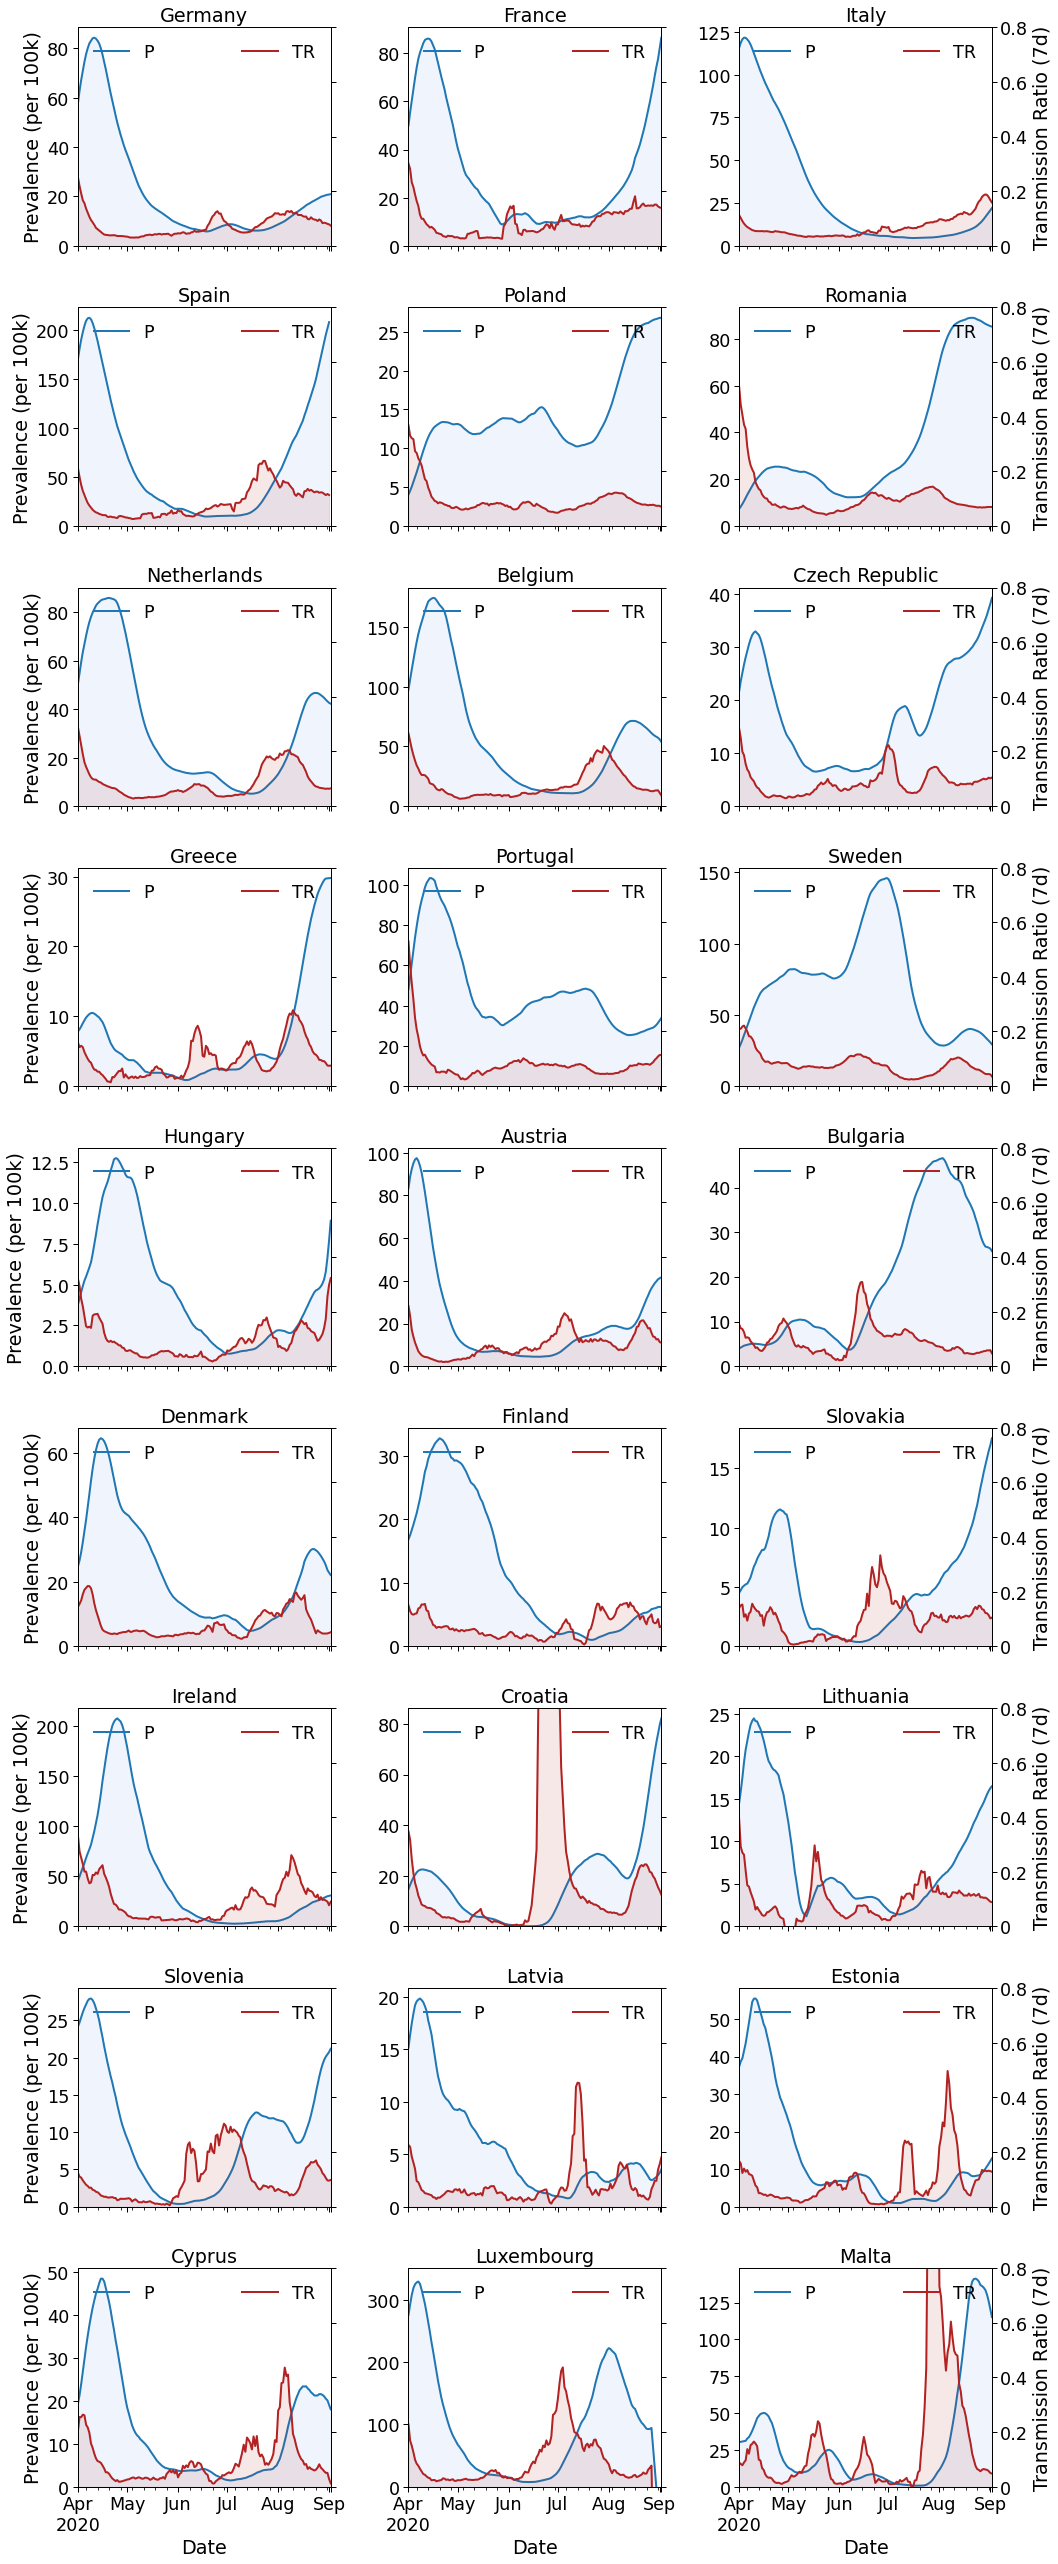

In [75]:
sns.set_context('paper', font_scale=2)

nrows, ncols = 9, 3

h, w = 4, 5

eu = df['region']=='eu'


fig, axes = plt.subplots(figsize=(ncols*w, nrows*h), ncols=ncols, nrows=nrows, sharex=True, sharey=False)

axs = axes.flatten()

for i, (ax, country) in enumerate(zip(axs, df[eu].sort_values(by='population', ascending=False)['country'].unique())):
    
    data = df[df['country']==country].set_index('date').loc[datetime(2020, 4, 1):]
    
    ax, bx = plot_prevalence_and_transmission_rate(data, ax)
    
    ax.set_ylim(0)
    bx.set_ylim(0, .8)
    bx.set_yticks(np.arange(0, .81, .2))
    bx.set_yticklabels([])

    if i%ncols==0: ax.set_ylabel('Prevalence (per 100k)')
        
    if i%ncols==ncols-1: 
        bx.set_yticklabels([0, .2, .4, .6, .8])
        bx.set_ylabel('Transmission Ratio (7d)')
        
    if i>ncols*(nrows-1)-1: ax.set_xlabel('Date')

    ax.legend(['P'], frameon=False, loc=2)
    bx.legend(['TR'], frameon=False, loc=1)

fig.tight_layout()

fig.savefig('graphs/prevalence_and_transmission_ratio_by_day_for_europe.png', format='png')

In the above we see the prevalence and transmission ratios for the 27 EU countries and once again we can see how the transmission ratio can act as a leading indicator of changes in prevalence. For example, in countries such as Belgium, the Netherlands, the Czech Republic, and Luxemburg, among others, the transmission ratio rose during the sumnmer in advance of a sustained growth in prevalence, before peaking and then declining ahead of a prevalence reduction. This is exactly the type of behaviour one would expect from an r-like metric. The advantage is the ease with which the transmission ratio can be calculated and the compromise is that it will provide a less reliable account of true transmission, but one that may be good enough for many purposes. As with the *r* number metric, the transmission ratio is sensitive to low numbers of cases and in such situations its direction of movement may be more useful than the transmission ratio value itself. For example, there was a very large transmission ration spike in Malta in late July as cases started to grow from a near-zero baseline and we can see a similar effect in Croatia in June; nevertheless in both countries the increase in the transmission ratio a spike in prevalence and the subsequent decline in transmission ratio preceeded a drop in prevalence.